# Загрузка начальных данных

Автор: Никоноров Е.Н.
Дата: 21.11.2022
Курс: Аналитик данных (Data scientist) 2022
Кейс: №3 «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

Описание файла:
1. Загружаем данные из ebw_data.xlsx
2. Анализируем данные на пропуски и т.п.
3. Формируем финальный датасет
4. Генерируем доп. данные
5. Выгружаем датасет в файл ds_initial, ds_merged.xlsx
6. Выгружаем сгенерированный датасет в файл ds_generated.xlsx

Импорт библиотек

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

import matplotlib.pyplot as plt


In [14]:
!pip install sdv

     -------------------------------------- 102.1/102.1 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
  Using cached copulas-0.7.0-py2.py3-none-any.whl (53 kB)
  Using cached Faker-14.2.1-py3-none-any.whl (1.6 MB)
  Using cached deepecho-0.3.0.post1-py2.py3-none-any.whl (26 kB)
     ---------------------------------------- 61.8/61.8 kB ? eta 0:00:00
     -------------------------------------- 132.0/132.0 kB 2.0 MB/s eta 0:00:00
  Using cached cloudpickle-2.2.0-py3-none-any.whl (25 kB)
  Using cached ctgan-0.5.2-py2.py3-none-any.whl (24 kB)
     ---------------------------------------- 1.1/1.1 MB 4.3 MB/s eta 0:00:00
     -------------------------------------- 167.3/167.3 MB 5.7 MB/s eta 0:00:00
     -------------------------------------- 210.1/210.1 kB 6.4 MB/s eta 0:00:00
  Using cached plotly-5.11.0-py2.py3-none-any.whl (15.3 MB)
  Attempting uninstall: p

Загрузка файлов

In [2]:
df1 = pd.read_excel("../Data/Raw/ebw_data.xlsx")
df1

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
...,...,...,...,...,...,...
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76


Предварительный анализ

In [5]:
df1.info()
#Null нет
df1.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


0

Анализ

In [6]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


In [7]:
#Количество уникальных значений
df1.nunique()
df1.duplicated().sum()
df1.isna()
df1.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [9]:
#Гистограммы
from matplotlib.colorbar import colorbar_factory
def histodraw(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.histplot(data=df, x=var_name, kde=True,bins=30, color = 'red')
        fig.tight_layout()
        plt.show()
        histodraw(df, df.columns, 4, 4)

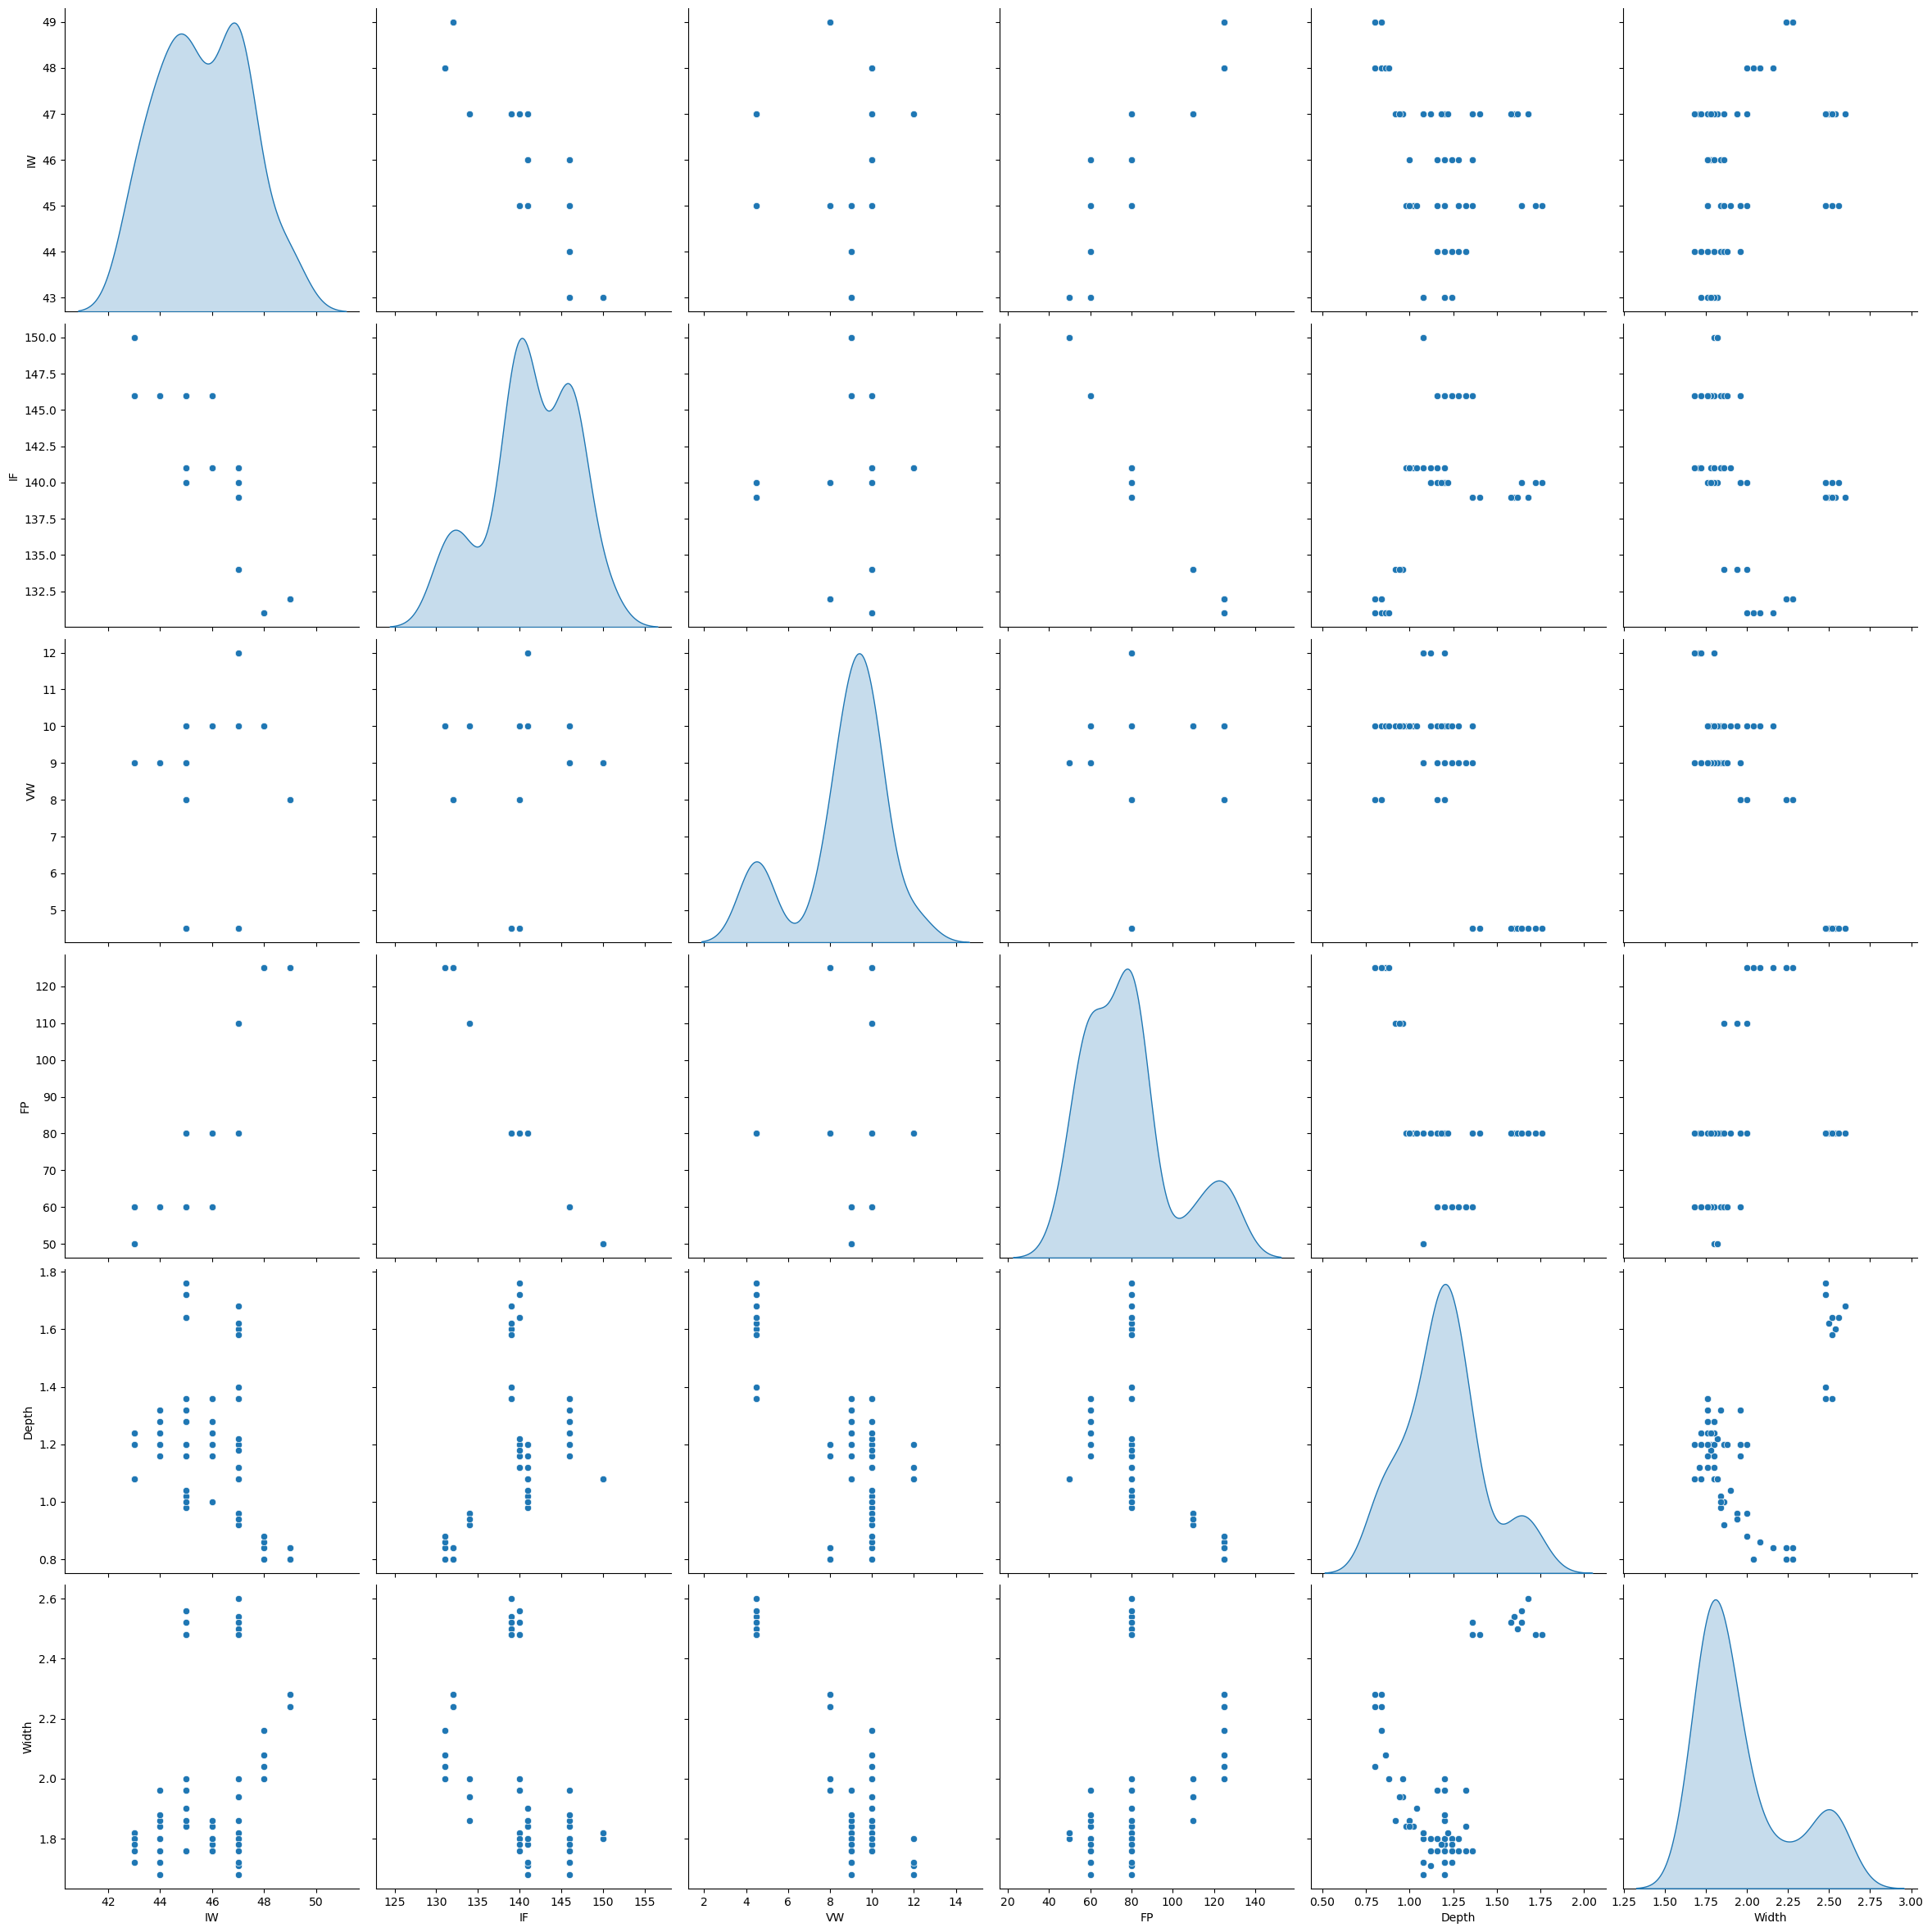

In [12]:
#Попарные графики рассеяния
sns.pairplot(df1, height=4, diag_kind='kde');

In [131]:
import warnings
warnings.filterwarnings("ignore")

#CTGAN,GaussianCopula, CopulaGAN - плохо генерирует
#генерация даных
from sdv.tabular import TVAE
from sdv.evaluation import evaluate


model = TVAE(epochs=2000, 
                 compress_dims=(512,512,512),   
                 decompress_dims=(512,512,512), 
                 embedding_dim=4,
                 l2scale=1e-5, loss_factor=2
                ) 
    
model.fit(df1)
    

In [132]:
df_gen_best=model.sample(num_rows=100)
listev = []
listev.append(0)

for x in range(0, 500):
    
    gen_data = model.sample(num_rows=1000)
    ev = evaluate(gen_data, df1)    
    
    if max(listev) < ev:
        df_gen_best = gen_data
    
    listev.append(ev)
    #print(ev)

print('вывод')
print(max(listev))
    

вывод
0.9250185185185185


In [133]:
df1

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
...,...,...,...,...,...,...
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76


In [134]:
#объединение датасетов

merged_data = df1.append(df_gen_best)
merged_data

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
...,...,...,...,...,...,...
995,44,149,9.4,54,1.08,1.84
996,47,140,10.0,80,1.13,1.77
997,45,140,8.2,80,1.33,1.95
998,46,142,9.9,80,1.15,1.82


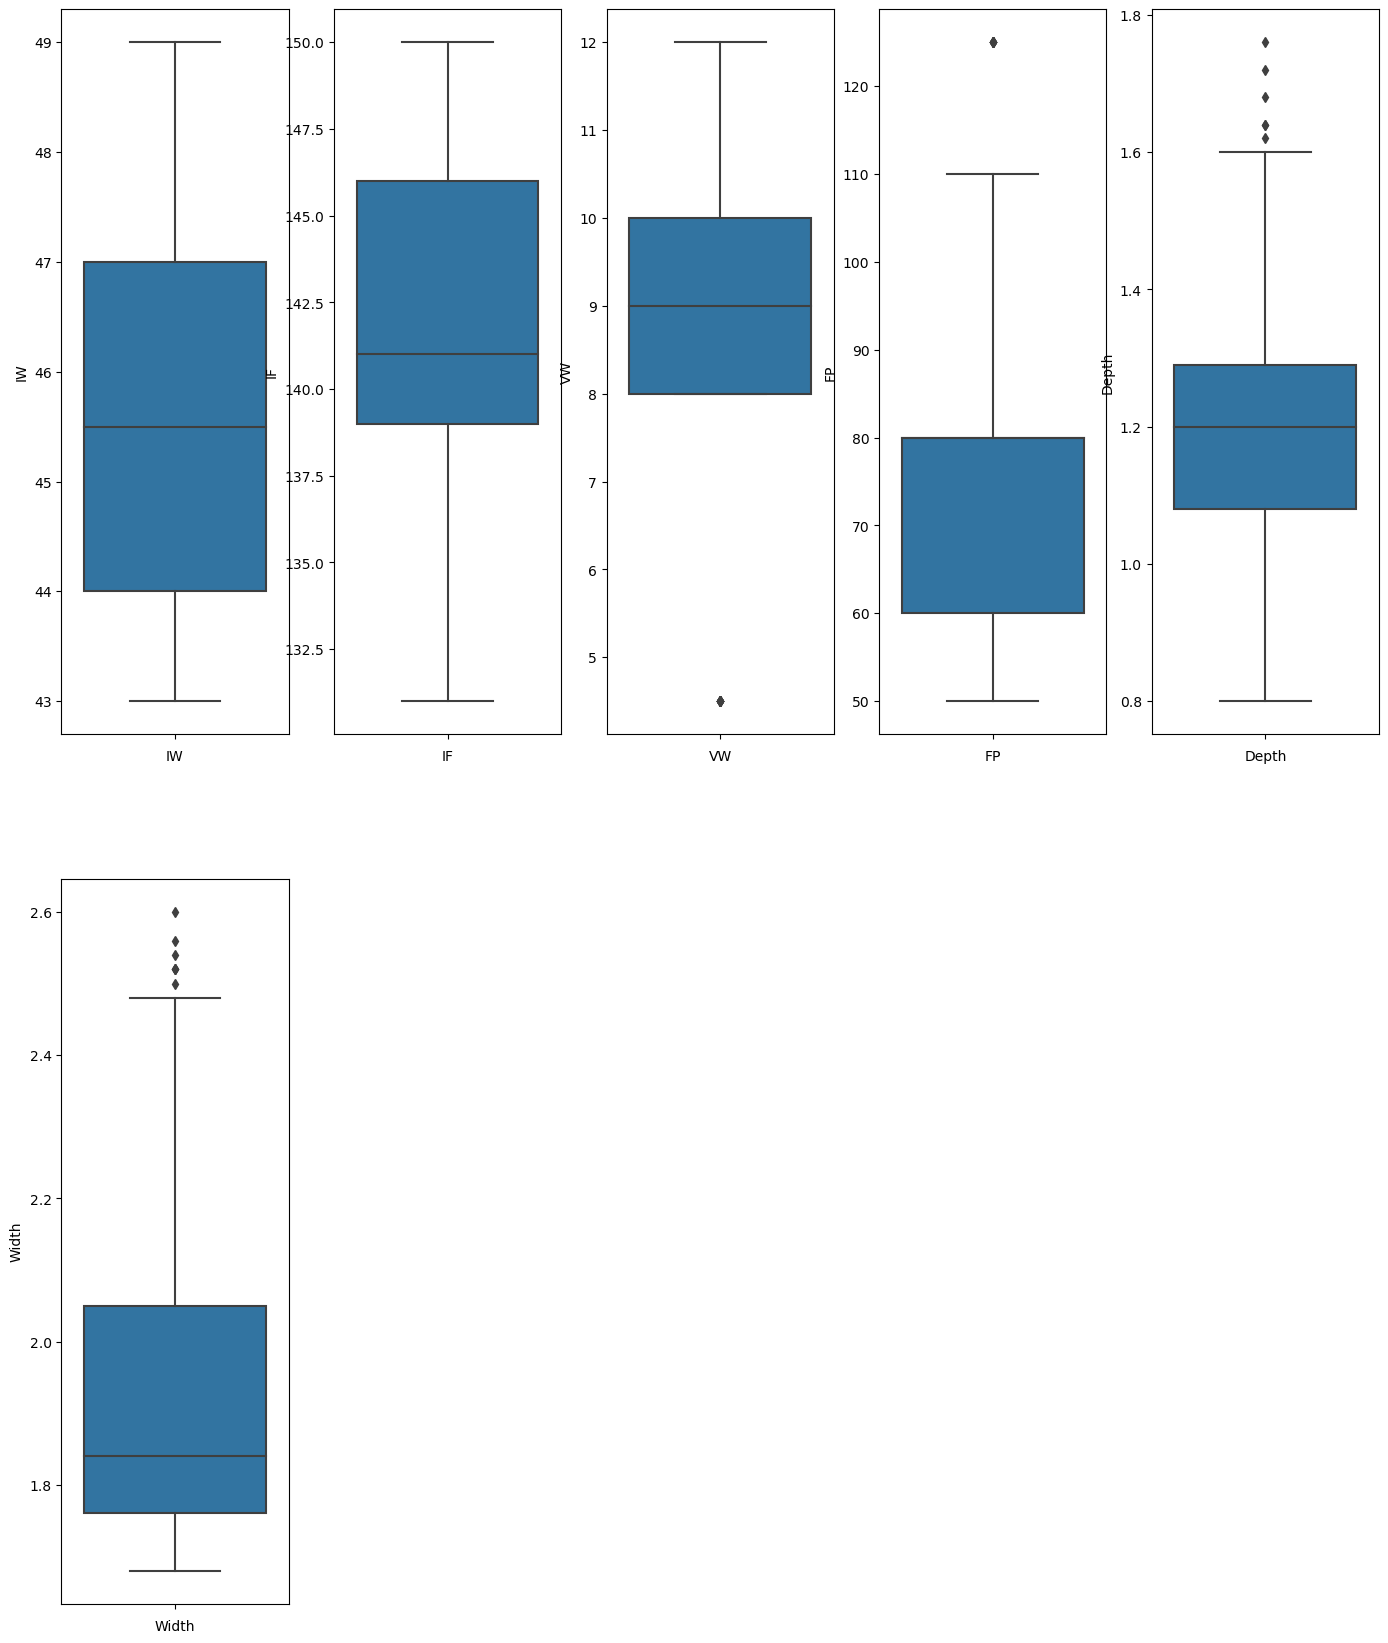

In [137]:
#Диаграмма "Ящик с усами" до удаления выбросов
n = 1 # счетчик
s = 3 # строки
c = 5 # столбцы
fig = plt.figure(figsize=(17, 32))
for i in df1.columns:
    plt.subplot(s, c, n)
    plt.xlabel(i)
    sns.boxplot(y = df1[i])
    n = n + 1
plt.show()

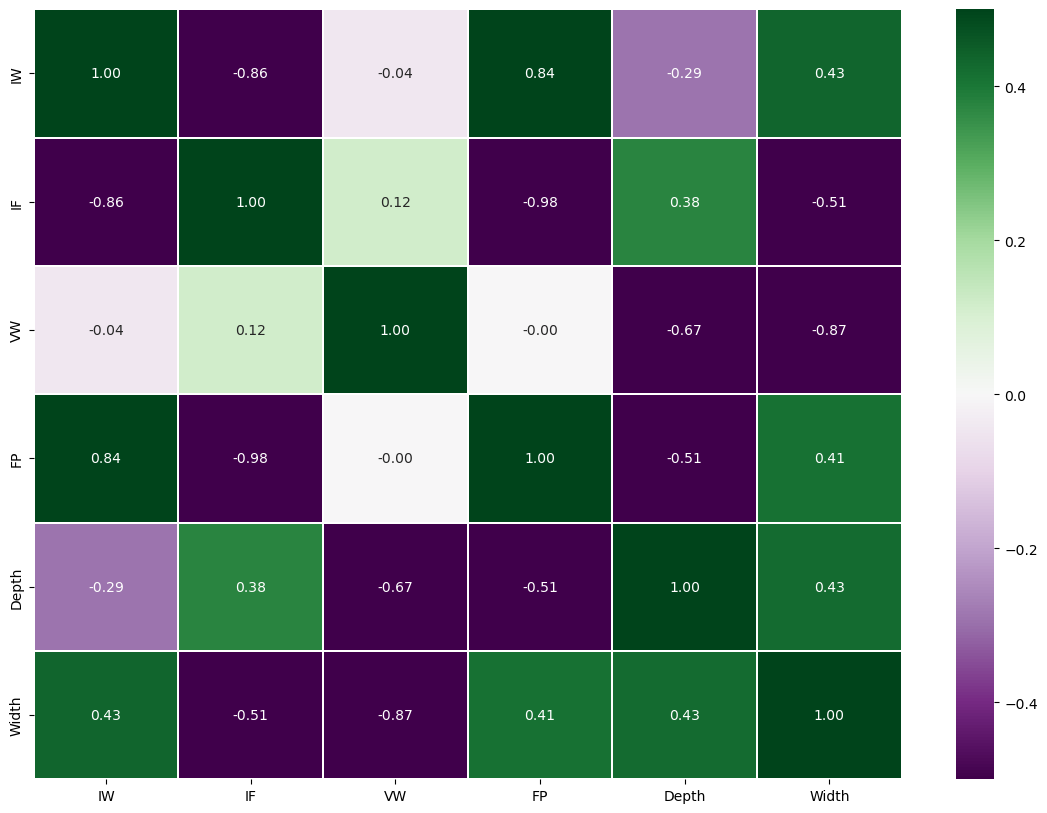

In [138]:
#Визуализация данных с помощью корреляционной матрицы до удаления выбросов
cor_map = df1.corr()
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(cor_map, vmin=-0.5, vmax=0.5, annot=True,
fmt='.2f',cmap='PRGn', ax=ax, linewidths = 0.1)
plt.show()

In [139]:
#Корреляции между переменными на тепловой карте выявлены от 0.4 до 0.9
#Сравнение двух методов удаления выбросов: 3-х сигм или межквартильных расстояний
sgm = 0
iqd= 0
for column in df1:
    d = df1.loc[:, [column]]
    # методом 3-х сигм
    zscore = (df1[column] - df1[column].mean()) / df1[column].std()
    d['3s'] = zscore.abs() > 3
    sgm += d['3s'].sum()
    # методом межквартильных расстояний
    q1 = np.quantile(df1[column], 0.25)
    q3 = np.quantile(df1[column], 0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    d['iq'] = (df1[column] <= lower) | (df1[column] >= upper)
    iqd+= d['iq'].sum()

print( sgm,'-- выброс методом 3-х сигм',)
print( iqd,'-- выброс методом межквартильных расстояний',)

0 -- выброс методом 3-х сигм
37 -- выброс методом межквартильных расстояний


In [140]:
#Распределение выбросов по характеристикам
temp_dataFrame = df1.copy()
for i in df1.columns:
    print(f"_______________________________________")
    temp_dataFrame[i] = abs((df1[i] -
    df1[i].mean()) / df1[i].std())
    print(f"{sum(temp_dataFrame[i] > 3)} -> выбросов в признаке:'{i}'")
    print(f' Всего - {sum(sum(temp_dataFrame.values > 3))} выброса')

_______________________________________
0 -> выбросов в признаке:'IW'
 Всего - 216 выброса
_______________________________________
0 -> выбросов в признаке:'IF'
 Всего - 144 выброса
_______________________________________
0 -> выбросов в признаке:'VW'
 Всего - 72 выброса
_______________________________________
0 -> выбросов в признаке:'FP'
 Всего - 0 выброса
_______________________________________
0 -> выбросов в признаке:'Depth'
 Всего - 0 выброса
_______________________________________
0 -> выбросов в признаке:'Width'
 Всего - 0 выброса


In [143]:
#Удаление выбросов не требуется (0 по методу 3х сигм)
df_drop = df1[(np.abs(stats.zscore(df1)) <= 3).all(axis=1)]
df_drop

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
...,...,...,...,...,...,...
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76


<AxesSubplot:ylabel='Density'>

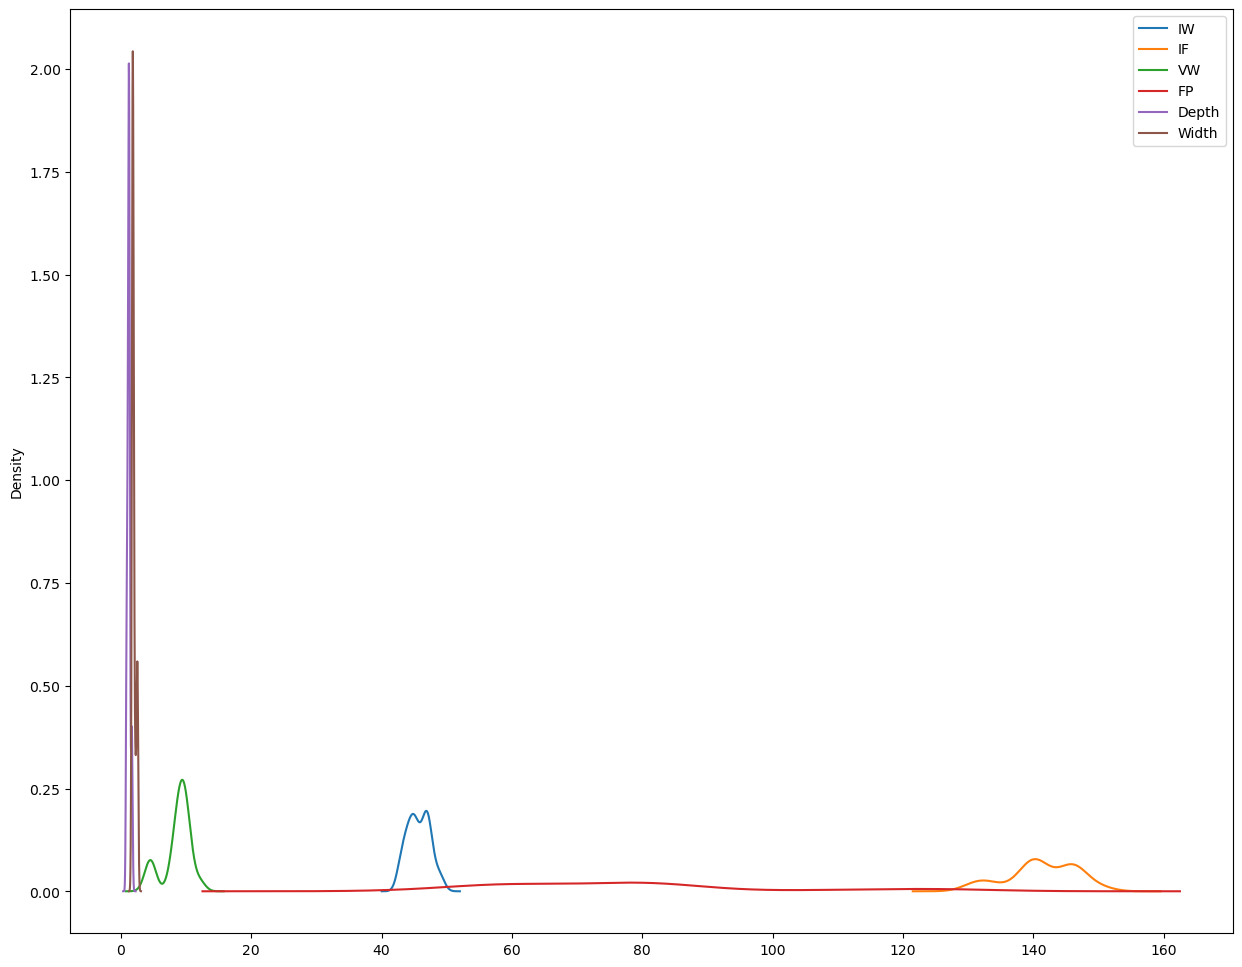

In [144]:
#Оценка плотности ядра
fig, ax = plt.subplots(figsize=(15, 12))
df1.plot(kind='kde', ax=ax)

In [145]:
#Видно, что данные находятся в разных диапазонах. Оценка плотности ядра показывает, что данные нужно нормализовать
scaler = preprocessing.MinMaxScaler()
names = df1.columns
d = scaler.fit_transform(df1)
df_norm = pd.DataFrame(d, columns=names)
df_norm.head()

,IW,IF,VW,FP,Depth,Width
0,0.666667,0.421053,0.0,0.4,0.833333,0.934783
1,0.666667,0.421053,0.0,0.4,0.854167,0.891304
2,0.666667,0.421053,0.0,0.4,0.916667,1.000000
3,0.666667,0.421053,0.0,0.4,0.812500,0.913043
4,0.333333,0.473684,0.0,0.4,1.000000,0.869565


In [148]:
names = df_gen_best.columns
d = scaler.fit_transform(df_gen_best)
df_gen = pd.DataFrame(d, columns=names)
df_gen.head()

,IW,IF,VW,FP,Depth,Width
0,0.333333,0.789474,0.600000,0.133333,0.531250,0.076087
1,0.000000,0.894737,0.600000,0.066667,0.468750,0.108696
2,0.166667,0.789474,0.600000,0.133333,0.531250,0.260870
3,0.833333,0.000000,0.733333,1.000000,0.052083,0.565217
4,0.500000,0.789474,0.706667,0.133333,0.447917,0.097826


In [159]:
names = merged_data.columns
d = scaler.fit_transform(merged_data)
df_merged = pd.DataFrame(d, columns=names)
df_merged.head()

,IW,IF,VW,FP,Depth,Width
0,0.666667,0.421053,0.0,0.4,0.833333,0.934783
1,0.666667,0.421053,0.0,0.4,0.854167,0.891304
2,0.666667,0.421053,0.0,0.4,0.916667,1.000000
3,0.666667,0.421053,0.0,0.4,0.812500,0.913043
4,0.333333,0.473684,0.0,0.4,1.000000,0.869565


In [151]:
#Описательная статистика характеристик после нормализации
df_norm.describe().T.round(2)
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     float64
 1   IF      72 non-null     float64
 2   VW      72 non-null     float64
 3   FP      72 non-null     float64
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(6)
memory usage: 3.5 KB


In [152]:
#Описательная статистика характеристик после нормализации
df_gen.describe().T.round(2)
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      1000 non-null   float64
 1   IF      1000 non-null   float64
 2   VW      1000 non-null   float64
 3   FP      1000 non-null   float64
 4   Depth   1000 non-null   float64
 5   Width   1000 non-null   float64
dtypes: float64(6)
memory usage: 47.0 KB


In [160]:
#Описательная статистика характеристик после нормализации
df_merged.describe().T.round(2)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      1072 non-null   float64
 1   IF      1072 non-null   float64
 2   VW      1072 non-null   float64
 3   FP      1072 non-null   float64
 4   Depth   1072 non-null   float64
 5   Width   1072 non-null   float64
dtypes: float64(6)
memory usage: 50.4 KB


Анализ зависимостей

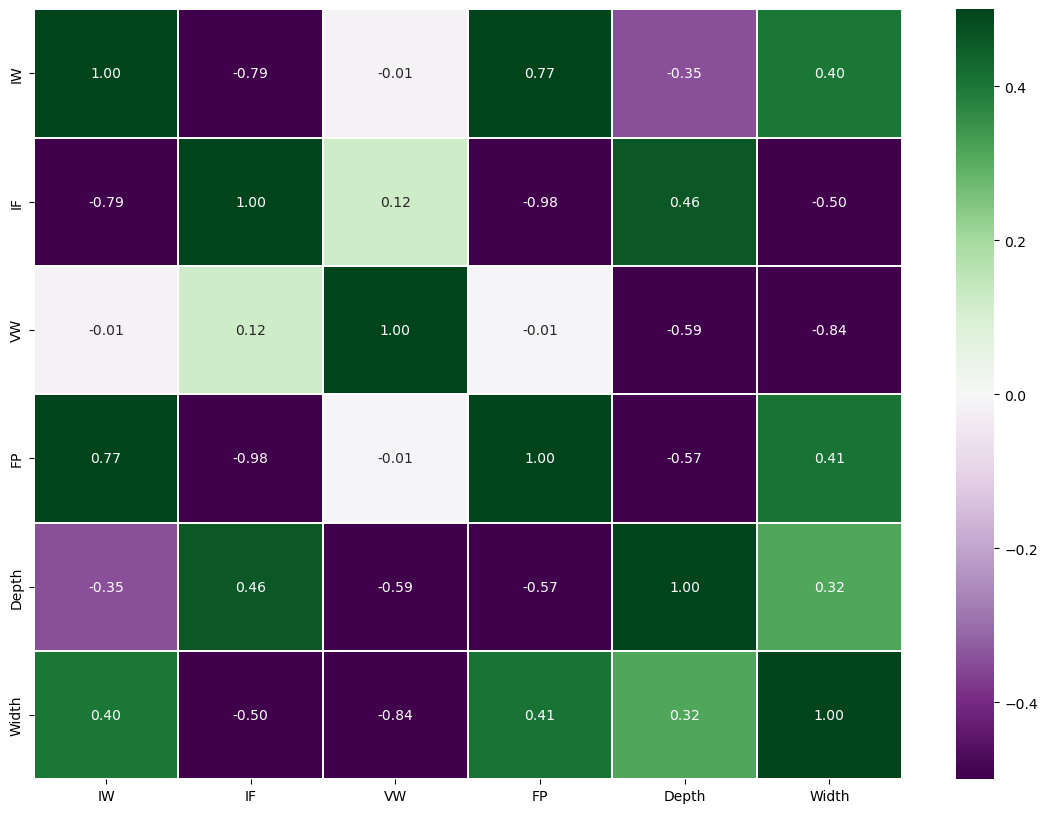

In [161]:
#Визуализация данных с помощью корреляционной матрицы 
cor_map = ds_merged.corr()
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(cor_map, vmin=-0.5, vmax=0.5, annot=True,
fmt='.2f',cmap='PRGn', ax=ax, linewidths = 0.1)
plt.show()

Сохраняем датасет в файл dataset_merged.xlsx 

In [170]:
df_norm.to_excel("../Data/ds_initial_norm.xlsx")

In [171]:
df_merged.to_excel("../Data/ds_merged.xlsx")

In [172]:
df_gen.to_excel("../Data/ds_generated.xlsx")

In [173]:
df1.to_excel("../Data/ds_initial.xlsx")

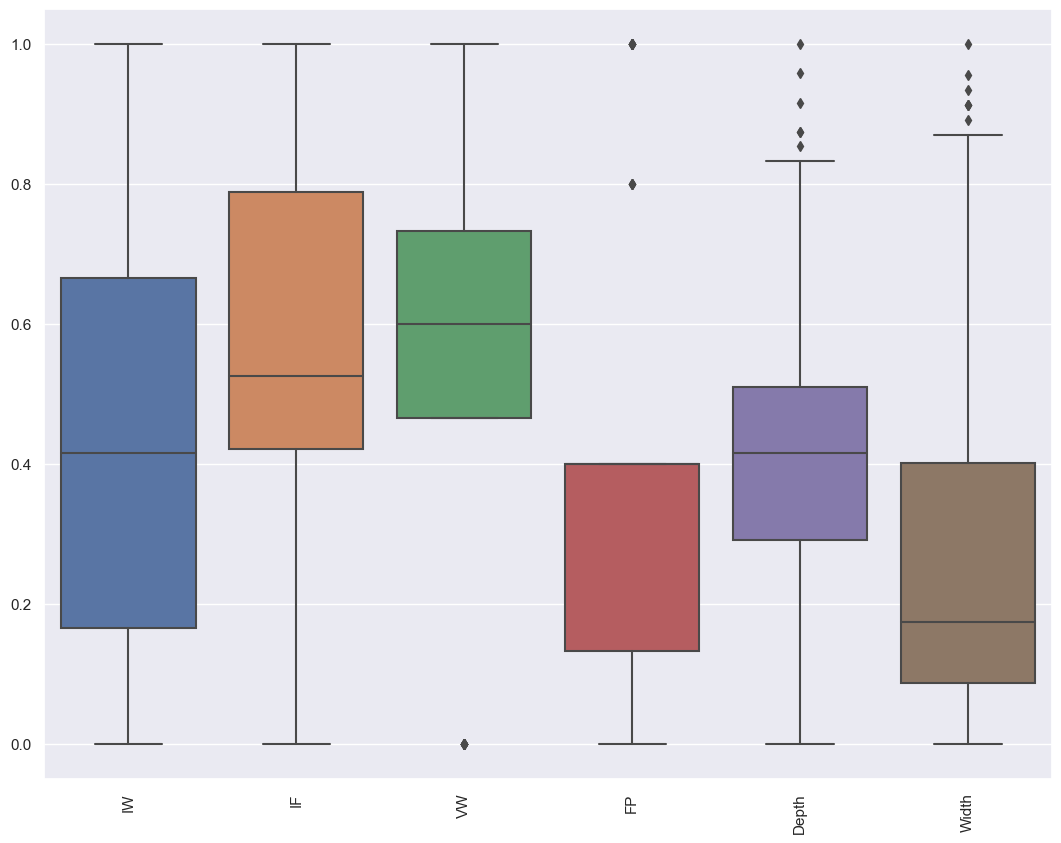

In [167]:
#Оценим ящик с усами после нормализации
min_max_scaler = preprocessing.MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df_norm),
columns = df_norm.columns, index = df_norm.index)
sns.set(rc={'figure.figsize':(13,10)})
ax = sns.boxplot(data=df_norm)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

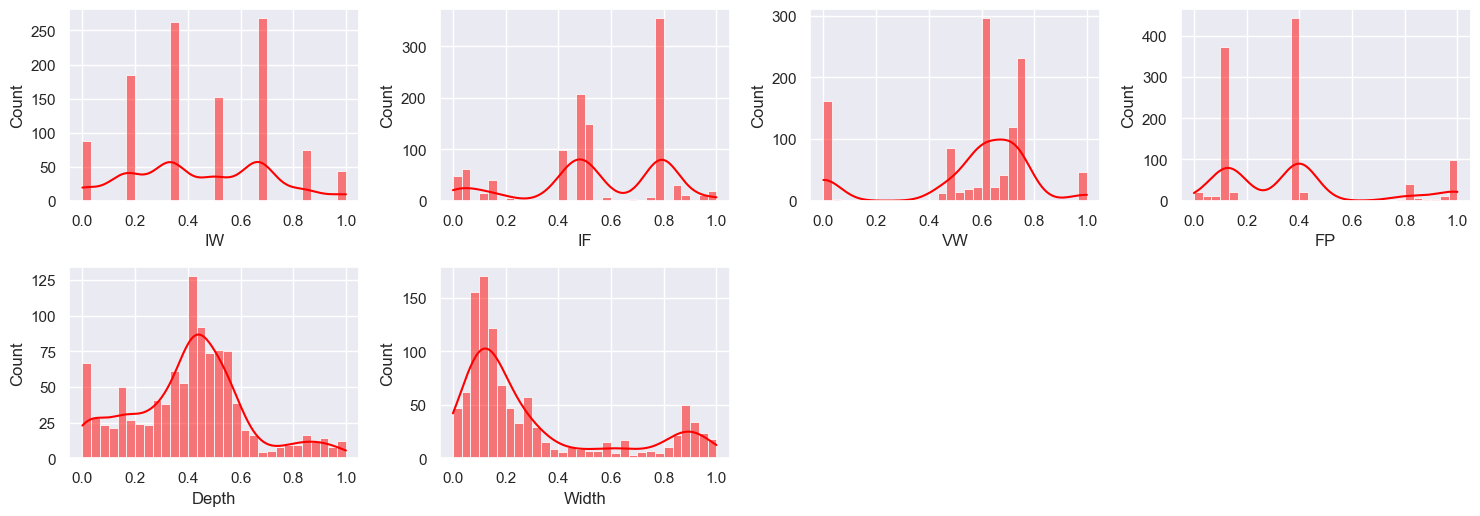

In [169]:
#Гистограмма после нормализации
from matplotlib.colorbar import colorbar_factory
def histodraw(join_dataFrame_drop_norm, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.histplot(data=join_dataFrame_drop_norm, x=var_name,
        kde=True, bins=30, color = 'red')
    fig.tight_layout()
    plt.show()

histodraw(df_merged, df_merged.columns, 4, 4)